In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=40, scale=0.0003, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
# tumor = tissue.Tissue(name='tumor', c=1550, rho=1050, sigma=0, scale=0.0001, label=5)
tumor = tissue.Tissue(name='tumor', c=1560, rho=1050, sigma=0, scale=0.001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = f"{parent}/assets/breast_phantom/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [4]:
test = test_phantom.get_complete()

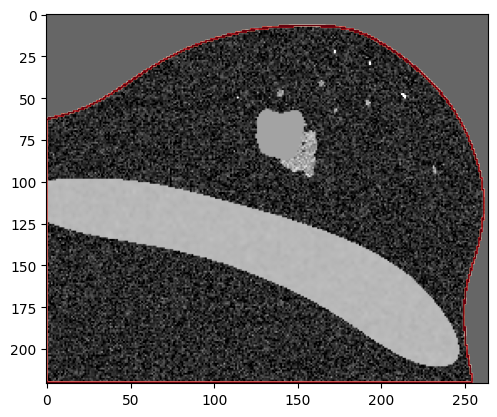

In [5]:
index = 140
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index] * 1000, alpha=0.5*(body_mask[:,:, index]>0)*2, cmap='Reds')

# Set up simulation

In [6]:
num_transducers = 1
transducers = [transducer.Planewave(max_frequency = 2e6,
                                  elements = 128, 
                                  width = 50e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/4,
                                  ray_num = 8,
                                  imaging_ndims = 2,
                                  focus_elevation = 60e-3) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [7]:
spread = np.pi * 0.23
position = [-0.07,0,0]
global_transform = geometry.Transform([-np.pi * 0.13,np.pi * -0.05,0],[0.003,0.003,-0.005], intrinsic=False)

transform1 = geometry.Transform([0,0,0], [0,0,0])
transform2 = geometry.Transform([0,0.2,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point([-0.07,-0.01,0.01], inverse=False)
test_transducer_set.assign_pose(0, global_transform * transform)

# transform1 = geometry.Transform([-spread / 3,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(0, global_transform * transform)

# transform1 = geometry.Transform([spread / 3,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(1, global_transform * transform)

# transform1 = geometry.Transform([-spread,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(2, global_transform * transform)

# transform1 = geometry.Transform([spread,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(3, global_transform * transform)

# transform1 = geometry.Transform([-spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * -spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(4, global_transform * transform)

# transform1 = geometry.Transform([-spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(5, global_transform * transform)

# transform1 = geometry.Transform([spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * -spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(6, global_transform * transform)

# transform1 = geometry.Transform([spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(7, global_transform * transform)

In [8]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [9]:
# np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:])/2
np.mean(test_sensor.sensor_coords, axis=0)

array([-0.06201749,  0.02327964,  0.00323013])

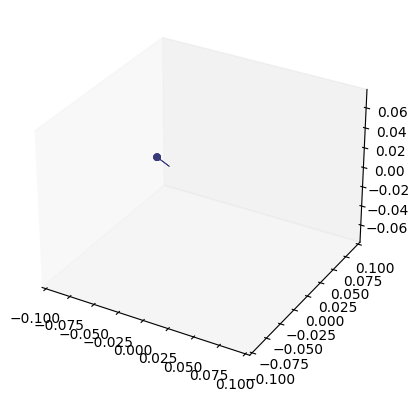

In [10]:
test_transducer_set.plot_transducer_fovs()

In [11]:
for i in range(len(test_transducer_set)):
    p = test_transducer_set[i][1]
    print(p.translation , p.rotation.as_euler('ZYX'))

[-0.06201748  0.02327964  0.00323013] [-0.40044979  0.0555453   0.0622638 ]


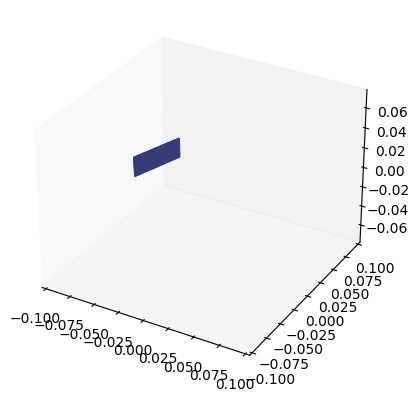

In [12]:
test_transducer_set.plot_transducer_coords()

In [13]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,100e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [14]:
# test_experiment = experiment.Experiment(
#                  simulation_path = 'breast_tomography',
#                  sim_properties  = simprops,
#                  phantom         = test_phantom,
#                  transducer_set  = test_transducer_set,
#                  sensor          = test_sensor,
#                  nodes           = 1,
#                  results         = None,
#                  indices         = None,
#                  workers         = 3,
#                  additional_keys = []
#                  )

test_experiment = experiment.Experiment(
                 simulation_path = 'breast_2D_planewave',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

test_experiment.save()

In [15]:
# utils.save_mrc(test_experiment.get_sensor_mask(pad=50), 'breast_tomography_sensor_mask.mrc')

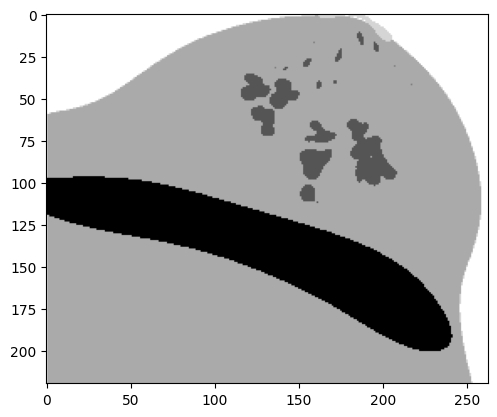

In [16]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

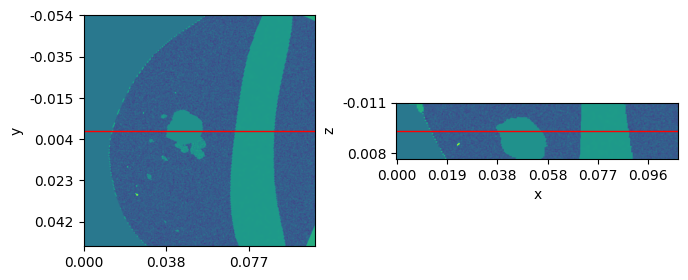

In [17]:
test_experiment.plot_ray_path(0)

# Run Simulation

In [18]:
test_experiment = experiment.Experiment.load('breast_2D_planewave')
test_experiment.run(dry=True)

dry run of simulation


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


In [19]:
test_experiment.run(repeat=True)

running with 2 workers

preparation for sim    0 completed in 94.56 seconds
preparation for sim    1 completed in 94.50 seconds
simulation             0 completed in 319.37 seconds
preparation for sim    2 completed in 94.23 seconds
simulation             1 completed in 316.07 seconds
preparation for sim    3 completed in 93.69 seconds
simulation             2 completed in 319.99 seconds
preparation for sim    4 completed in 93.86 seconds
simulation             3 completed in 315.63 seconds
preparation for sim    5 completed in 93.77 seconds
simulation             4 completed in 319.81 seconds
preparation for sim    6 completed in 93.77 seconds
simulation             5 completed in 315.59 seconds
preparation for sim    7 completed in 94.98 seconds
simulation             6 completed in 320.71 seconds
simulation             7 completed in 315.02 seconds
successfully joined 1 preparation processes and 1 run process


# Reconstruction

In [20]:
test_experiment = experiment.Experiment.load('breast_2D_planewave')
test_experiment.run(dry=True)
test_experiment.add_results()

dry run of simulation


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


In [21]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [22]:
images2 = test_reconstruction.compound(workers=5, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 8/8 [00:00<00:00, 179435.47it/s]


In [23]:
image2 = np.sum(images2, axis=0)/len(images2)

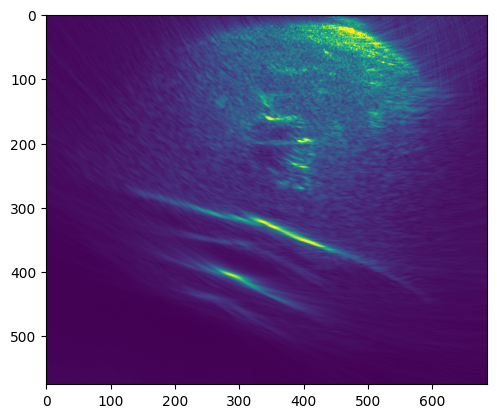

In [24]:
plt.imshow(image2[:,:,0], vmin=0, vmax=300)

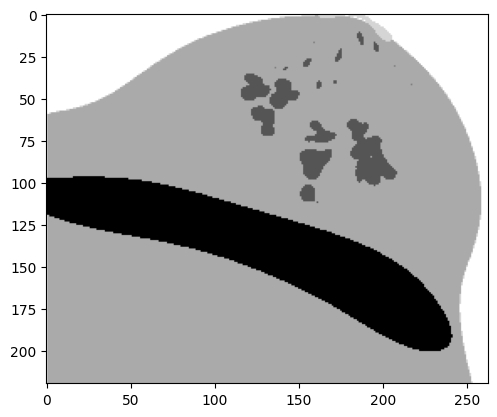

In [28]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

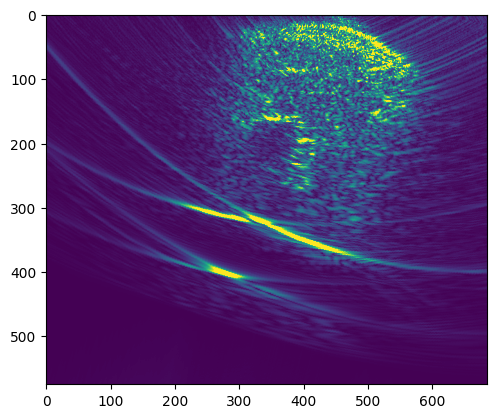

In [31]:
plt.imshow(images2[5][:,:,0], vmin=0, vmax=300)